In [1]:
import pyopencl as cl
from pyopencl.elementwise import ElementwiseKernel
import pyopencl.array as cla
import pyopencl.clmath as clm
from pyopencl.elementwise import ElementwiseKernel
import numpy as np
import math
import time
import soundfile
from scipy import signal as sgn
import gammatone.filters as oldfilt
import gammatonecl.filters as newfilt
from matplotlib import pyplot as plt
from tqdm import tqdm
from pyopencl.scan import GenericScanKernel

ctx = cl.create_some_context()
q = cl.CommandQueue(ctx)
M_PI = 3.14159265358979323846
BW_CORRECTION = 1.0190

def erb(x):
    return 24.7 * ( 4.37e-3 * x + 1.0 )

In [22]:
samples, fs = soundfile.read('04 Traffic and Weather.flac')
samples = np.ascontiguousarray(samples[:9557352//2, 0])
samp_g = cla.to_device(q, samples)
coseed = 1
sineed = 0
tpt = (M_PI + M_PI) / 44100
tptbw = tpt * erb ( 5512.5 ) * BW_CORRECTION
coscf = math.cos(tpt*5512.5)
sincf = math.cos(tpt*5512.5)
ts = np.arange(0, len(samples), dtype=np.float64)
decay = np.exp(-tptbw)
gain = np.float64((tptbw ** 4) / 3)
gain

2.1842638127896094e-05

In [4]:
q_maker = ElementwiseKernel(ctx,
                            "double *qcos, double *qsin, double *t, double tpt, double cf",
                            "qcos[i] = cos(tpt * cf * t[i]); qsin[i] = - sin(tpt * cf * t[i])"
                            )

In [5]:
t0 = time.time()
ts_g = cla.to_device(q, ts)
qcos = cla.empty_like(ts_g)
qsin = cla.empty_like(ts_g)
q_maker(qcos, qsin, ts_g, tpt, 5512.5)
cosx = samp_g * qcos
sinx = samp_g * qsin
print(f'That took {time.time() - t0} seconds.')
# qcos and qsin can be preprocessed very quickly

That took 0.01180410385131836 seconds.


In [54]:
p0 = GenericScanKernel(ctx, np.float64,
                            arguments='double *x, double *y',
                            neutral='0',
                            input_expr='x[i]',
                            scan_expr='a',
                            output_statement="""y[i] = item * 4.0 * 0.9139569249435527 - 6.0 * y[i-2] * 0.9139569249435527 * 0.9139569249435527 +
                                                4.0*y[i-3]*0.9139569249435527*0.9139569249435527*0.9139569249435527 + y[i-4]*0.9139569249435527*0.9139569249435527*0.9139569249435527*0.9139569249435527 + x[i];
                                                y[i-1] = y[i-2]; y[i-2] = y[i-3]; y[i-3] = y[i-4]"""
                            )

u0 = ElementwiseKernel(ctx,
                       'double *p0, double *y',
                       'y[i] = p0[i] + 4.0 * 0.9139569249435527 * p0[i-1] + 0.9139569249435527*0.9139569249435527*p0[i-2]')

bm_maker = ElementwiseKernel(ctx,
                             'double *ur, double *ui, double *qcos, double *qsin, double *y',
                             'y[i] = (ur[i] * qcos[i] + ui[i] * qsin[i]) * 2.1842638127896094e-05')

That took 0.009856700897216797 seconds


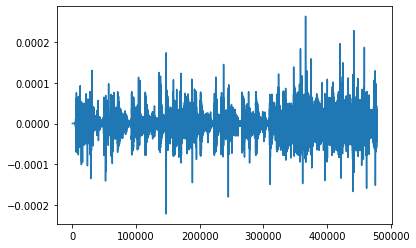

In [55]:
bm_g = cla.empty_like(ts_g)
pr_g = cla.empty_like(ts_g)
pi_g = cla.empty_like(ts_g)
ur_g = cla.empty_like(ts_g)
ui_g = cla.empty_like(ts_g)
t0 = time.time()
p0(cosx, pr_g)
p0(sinx, pi_g)
u0(pr_g, ur_g)
u0(pi_g, ui_g)
bm_maker(ur_g, ui_g, qcos, qsin, bm_g)
print(f'That took {(time.time() - t0)} seconds')
plt.plot(bm_g.get())

that took 0.14272499084472656 seconds


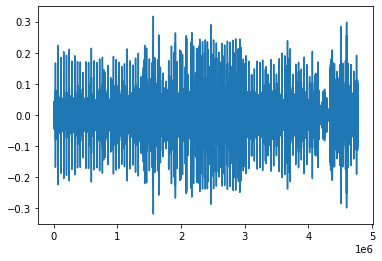

In [27]:
from gammatone import gtgram
t0 = time.time()
coefs = gtgram.make_erb_filters(44100, 5512.5)
x = gtgram.erb_filterbank(samples, coefs)[0]
print(f'that took {time.time() - t0} seconds')
plt.plot(x)

In [97]:
test_g = cla.arange(q, 0, 10, dtype=np.float64)
y_g = cla.zeros_like(test_g)
z_g = cla.zeros_like(test_g)

test_scan = GenericScanKernel(ctx, np.float64,
                              arguments='double *x, double *y, double *z',
                              neutral='0',
                              input_expr='x[i]',
                              scan_expr='a + b',
                              output_statement='y[i] = item, z[i] = y[i] + prev_item')

test_scan(test_g, y_g, z_g)
x = test_g.get()
y = y_g.get()
z = z_g.get()
out = np.row_stack([x,z,y])
print(out)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
 [ 0.  1.  3.  6. 10. 15. 21. 28. 36. 45.]]


In [29]:
elem = ElementwiseKernel(ctx,
                         "double *x, double *y",
                         "y[i] = x[i-1] + y[i-1]")

In [30]:
test_g = cla.arange(q, 0, 10, dtype=np.float64)
y_g = cla.zeros_like(test_g)
elem(test_g, y_g)
y_g

array([0., 0., 1., 2., 3., 4., 5., 6., 7., 8.])

NameError: name 'x' is not defined